<a href="https://colab.research.google.com/github/leeshirley2002/EECE7370_final_project/blob/main/Majority_Voting_Fusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import tarfile
from google.colab import drive
drive.mount('/content/drive')

# Directory for extraction
tmp_dir = "/content/tmp_extract"
os.makedirs(tmp_dir, exist_ok=True)

tar_path = "/content/drive/MyDrive/Colab Notebooks/EECE7370/exported_data.tar.gz"
dataset_path = "/content/drive/MyDrive/Colab Notebooks/EECE7370/"

# Extract dataset
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=tmp_dir, filter="data")

Mounted at /content/drive


In [ ]:
# MOUTH CONFIGURATION
REAL_MOUTH_DIR = "/content/tmp_extract/Features/original/mouth"
FAKE_MOUTH_DIR = "/content/tmp_extract/Features/manipulated/mouth"

MOUTH_MODEL_WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/EECE7370/Model_mouth/CNN_Mouth_best_1207_0909.pth"
MOUTH_IMG_SIZE = 64
MOPUTH_BATCH_SIZE = 64

# EYES CONFIGURATION
EYES_DATA_ROOT = "/content/tmp_extract"
EYES_MODEL_WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/EECE7370/Model_eyes_nose/model_a_eyes_best.pth"

EYES_IMG_SIZE = 50
EYES_BATCH_SIZE = 32

# FACE CONFIGURATION
REAL_FACE_DIR = "/content/tmp_extract/CroppedFaces/original"
FAKE_FACE_DIR = "/content/tmp_extract/CroppedFaces/manipulated"

FACE_MODEL_WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/EECE7370/Model_face/paper_model_c_best.pth"

FACE_IMG_SIZE = 224
FACE_BATCH_SIZE = 64

In [ ]:
# MOUTH DATASET & DATALOADER

def mouth_image_transform(img, img_size=64):
    img = img.resize((img_size, img_size))
    arr = np.array(img).astype(np.float32) / 255.0
    arr = np.transpose(arr, (2, 0, 1))  # HWC -> CHW
    return torch.from_numpy(arr)

class Mouth_TransformWrapper:
    def __init__(self, img_size=64):
        self.img_size = img_size

    def __call__(self, img):
        return mouth_image_transform(img, self.img_size)


class MouthDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.samples = []
        self.transform = transform

        real_dir = Path(real_dir)
        fake_dir = Path(fake_dir)

        # Label 0 for real images
        for ext in ["*.jpg", "*.png", "*.jpeg"]:
            for p in real_dir.glob(ext):
                self.samples.append((p, 0))

        # Label 1 for fake images
        for ext in ["*.jpg", "*.png", "*.jpeg"]:
            for p in fake_dir.glob(ext):
                self.samples.append((p, 1))

        # Sort samples for deterministic order
        self.samples.sort(key=lambda x: str(x[0]))
        print(f"[MouthDataset] Total samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)
        return img, label, str(img_path)


def create_mouth_dataloader(
    real_dir,
    fake_dir,
    img_size=64,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
):
    transform = Mouth_TransformWrapper(img_size=img_size)
    dataset = MouthDataset(real_dir, fake_dir, transform=transform)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return dataset, loader

In [ ]:
# EYES DATASET & DATALOADER

def eyes_image_transform(img_bgr, img_size=50):
    """Resizes and normalizes eye region using OpenCV."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_resized = img_resized.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
    return img_tensor


class EyesDataset(Dataset):
    """
    Dataset for eyes region (leftEye + rightEye).
    Returns (img_tensor, label_tensor, path_str).
    """
    def __init__(self, data_root, img_size=50):
        self.img_size = img_size
        self.file_paths = []
        self.labels = []

        # Get file paths for 'leftEye' and 'rightEye' regions
        regions = ["leftEye", "rightEye"]

        for r in regions:
            # Original (real) - label 0
            folder_real = os.path.join(data_root, "Features", "original", r)
            if os.path.exists(folder_real):
                for filename in os.listdir(folder_real):
                    self.file_paths.append(os.path.join(folder_real, filename))
                    self.labels.append(0)

            # Manipulated (fake) - label 1
            folder_fake = os.path.join(data_root, "Features", "manipulated", r)
            if os.path.exists(folder_fake):
                for filename in os.listdir(folder_fake):
                    self.file_paths.append(os.path.join(folder_fake, filename))
                    self.labels.append(1)

        # Sort by path for deterministic order
        paired = list(zip(self.file_paths, self.labels))
        paired.sort(key=lambda x: x[0])
        self.file_paths = [p for p, _ in paired]
        self.labels = [l for _, l in paired]

        print(f"[EyesDataset] Total samples: {len(self.file_paths)}")
        if len(self.file_paths) > 0:
            print(f"[EyesDataset] Real: {self.labels.count(0)}, Fake: {self.labels.count(1)}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        img_bgr = cv2.imread(img_path)
        img_tensor = eyes_image_transform(img_bgr, self.img_size)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor, label_tensor, str(img_path)


def create_eyes_dataloader(
    data_root,
    img_size=50,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
):
    """
    Builds eyes dataloader for evaluation.
    """
    dataset = EyesDataset(data_root=data_root, img_size=img_size)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return dataset, loader

In [ ]:
# FACE TRANSFORM
face_val_transform = transforms.Compose([
    transforms.Resize((FACE_IMG_SIZE, FACE_IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class FaceDataset(Dataset):
    """
    Full-face dataset for deepfake detection.
    Directory structure:
        REAL_FACE_DIR: /.../CroppedFaces/original
        FAKE_FACE_DIR: /.../CroppedFaces/manipulated
    Returns (image_tensor, label_tensor, path_str).
    """
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = Path(real_dir)
        self.fake_dir = Path(fake_dir)
        self.transform = transform

        self.samples = []

        # Label 0 for real images
        if self.real_dir.exists():
            for ext in ["*.jpg", "*.png", "*.jpeg"]:
                for p in self.real_dir.glob(ext):
                    self.samples.append((p, 0))

        # Label 1 for fake images
        if self.fake_dir.exists():
            for ext in ["*.jpg", "*.png", "*.jpeg"]:
                for p in self.fake_dir.glob(ext):
                    self.samples.append((p, 1))

        # Sort for deterministic order
        self.samples.sort(key=lambda x: str(x[0]))

        num_real = sum(1 for _, lbl in self.samples if lbl == 0)
        num_fake = sum(1 for _, lbl in self.samples if lbl == 1)

        print(f"[FaceDataset] Total samples: {len(self.samples)}")
        print(f"[FaceDataset] Real: {num_real}, Fake: {num_fake}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[FaceDataset] Error loading {img_path}: {e}")
            img = Image.new("RGB", (FACE_IMG_SIZE, FACE_IMG_SIZE), color="black")

        if self.transform is not None:
            img = self.transform(img)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor, str(img_path)


def create_face_dataloader(
    real_dir,
    fake_dir,
    img_size=224,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
):
    """
    Builds dataloader for full-face model evaluation.
    """
    # Rebuild transform here to allow img_size configuration
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = FaceDataset(real_dir=real_dir, fake_dir=fake_dir, transform=transform)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return dataset, loader

In [ ]:
# MOUTH MODEL
class Model_mouth(nn.Module):
    def __init__(self, num_classes=2):
        super(Model_mouth, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 64->32
            nn.Dropout(0.3),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 32->16
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 16->8
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def load_mouth_model(weights_path, device, num_classes=2):
    model = Model_mouth(num_classes=num_classes).to(device)
    ckpt = torch.load(weights_path, map_location=device)

    if "model_state_dict" in ckpt:
        state_dict = ckpt["model_state_dict"]
    else:
        state_dict = ckpt

    model.load_state_dict(state_dict)
    model.eval()
    print(f"[load_mouth_model] Loaded weights from: {weights_path}")
    return model

In [ ]:
# EYES MODEL

class Model_eyes(nn.Module):
    """
    ModelA architecture for eye regions. Input: 50x50x3.
    """
    def __init__(self, num_classes=2):
        super(Model_eyes, self).__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x


def load_eyes_model(weights_path, device, num_classes=2):
    """
    Loads eyes model trained with ModelA architecture.
    The training script saves model.state_dict().
    """
    model = Model_eyes(num_classes=num_classes).to(device)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print(f"[load_eyes_model] Loaded weights from: {weights_path}")
    return model

In [ ]:
# MODEL C

class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, embed_dim: int = 1024, num_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)

        return x


class TransformerBlock(nn.Module):
    """Transformer encoder block"""
    def __init__(self, dim: int, heads: int, mlp_dim: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-norm architecture
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class SimpleCNNModule(nn.Module):
    """
    Simple CNN Module (Model C).
    Two Conv2D layers (32 filters, 3x3 kernel) + Max Pooling.
    """
    def __init__(self, in_channels=3, out_channels=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.out_channels = out_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)


class PaperViTModule(nn.Module):
    """
    Vision Transformer Module - processes CNN feature maps.
    """
    def __init__(self, feature_size: int, patch_size: int = 7,
                 dim: int = 1024, depth: int = 6, heads: int = 8,
                 mlp_dim: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.feature_size = feature_size
        self.patch_size = patch_size
        self.dim = dim
        self.depth = depth

        # Calculate number of patches
        self.n_patches = (feature_size // patch_size) ** 2

        # Patch embedding: convert patches to vectors
        self.patch_embed = nn.Conv2d(
            32, dim, kernel_size=patch_size, stride=patch_size
        )

        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches, dim))

        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]

        # Patch embedding: (B, 32, H, W) -> (B, dim, H', W')
        x = self.patch_embed(x)

        # Flatten spatial dimensions: (B, dim, H', W') -> (B, n_patches, dim)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, n_patches, dim)

        # Add position embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        return x  # (B, n_patches, dim)


class PaperModelC(nn.Module):
    """
    Model C from Paper: CNN-ViT for Full Face Detection.
    Architecture matches the paper exactly.
    """
    def __init__(
        self,
        img_size: int = 224,
        num_classes: int = 2,
        patch_size: int = 7,
        dim: int = 1024,
        depth: int = 6,
        heads: int = 8,
        mlp_dim: int = 2048,
        dropout: float = 0.1
    ):
        super().__init__()

        self.img_size = img_size

        # CNN Module
        self.cnn_module = SimpleCNNModule(in_channels=3, out_channels=32)

        # Calculate feature size after CNN (224 -> 112 after MaxPool)
        feature_size = img_size // 2

        # ViT Module (processes CNN features)
        self.vit_module = PaperViTModule(
            feature_size=feature_size,
            patch_size=patch_size,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classification Head
        self.classifier = nn.Linear(dim, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # CNN feature extraction: (B, 3, 224, 224) -> (B, 32, 112, 112)
        cnn_features = self.cnn_module(x)

        # ViT processing: (B, 32, 112, 112) -> (B, n_patches, dim)
        vit_features = self.vit_module(cnn_features)  # (B, n_patches, dim)

        # Global Average Pooling: (B, n_patches, dim) -> (B, dim)
        vit_features = vit_features.transpose(1, 2)  # (B, dim, n_patches)
        pooled = self.global_pool(vit_features).squeeze(-1)  # (B, dim)

        # Classification: (B, dim) -> (B, num_classes)
        logits = self.classifier(pooled)

        return logits

In [ ]:
# FACE MODEL LOADING

def load_face_model(weights_path, device, num_classes=2):
    """
    Loads full-face model (PaperModelC) from checkpoint.
    Model hyperparameters must match training-time values.
    """
    model = PaperModelC(
        img_size=224,
        num_classes=num_classes,
        patch_size=7,
        dim=1024,
        depth=6,
        heads=8,
        mlp_dim=2048,
        dropout=0.1,
    ).to(device)

    ckpt = torch.load(weights_path, map_location=device)

    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state_dict = ckpt["model_state_dict"]
        print("[load_face_model] Detected checkpoint dict with 'model_state_dict'.")
    else:
        state_dict = ckpt
        print("[load_face_model] Detected raw state_dict.")

    model.load_state_dict(state_dict)
    model.eval()
    print(f"[load_face_model] Loaded weights from: {weights_path}")
    return model

In [ ]:
# MOUTH MODEL LOADING & INFERENCE

def predict_mouth_batch(model, imgs, device):
    model.eval()
    imgs = imgs.to(device)

    with torch.no_grad():
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    return logits, probs, preds


def evaluate_mouth_model(model, dataloader, device, verbose=True):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_results = []

    with torch.no_grad():
        for imgs, labels, paths in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            total_loss += loss.item() * imgs.size(0)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Save per-sample results
            probs_np = probs.cpu().numpy()
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for pth, y_true, y_pred, prob_vec in zip(
                paths, labels_np, preds_np, probs_np
            ):
                # class 0 = real, 1 = fake
                all_results.append(
                    {
                        "path": pth,
                        "label": int(y_true),
                        "pred": int(y_pred),
                        "prob_real": float(prob_vec[0]),
                        "prob_fake": float(prob_vec[1]),
                    }
                )

    avg_loss = total_loss / max(1, total_samples)
    acc = total_correct / max(1, total_samples)

    if verbose:
        print(f"[Mouth] Eval Loss: {avg_loss:.4f} | Eval Acc: {acc:.4f} "
              f"({total_correct}/{total_samples})")

    return acc, all_results

In [ ]:
# EYES INFERENCE & EVALUATION

def predict_eyes_batch(model, imgs, device):
    """
    Runs one forward pass on a batch of eye crops.
    Returns logits, probabilities, and predicted labels.
    """
    model.eval()
    imgs = imgs.to(device)

    with torch.no_grad():
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    return logits, probs, preds


def evaluate_eyes_model(model, dataloader, device, verbose=True):
    """
    Evaluates eyes model on the given dataloader.
    Returns: overall_acc, results_list
    results_list elements:
        {
            "path": img_path,
            "label": int_label,
            "pred": int_pred,
            "prob_real": float,
            "prob_fake": float,
        }
    """
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_results = []

    with torch.no_grad():
        for imgs, labels, paths in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            total_loss += loss.item() * imgs.size(0)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            probs_np = probs.cpu().numpy()
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for pth, y_true, y_pred, prob_vec in zip(paths, labels_np, preds_np, probs_np):
                all_results.append(
                    {
                        "path": pth,
                        "label": int(y_true),
                        "pred": int(y_pred),
                        "prob_real": float(prob_vec[0]),
                        "prob_fake": float(prob_vec[1]),
                    }
                )

    avg_loss = total_loss / max(1, total_samples)
    acc = total_correct / max(1, total_samples)

    if verbose:
        print(f"[Eyes] Eval Loss: {avg_loss:.4f} | Eval Acc: {acc:.4f} "
              f"({total_correct}/{total_samples})")

    return acc, all_results

In [ ]:
# FACE INFERENCE & EVALUATION

def predict_face_batch(model, imgs, device):
    """
    Runs one forward pass on a batch of full-face images.
    Returns: logits, probs, preds.
    """
    model.eval()
    imgs = imgs.to(device)

    with torch.no_grad():
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    return logits, probs, preds


def evaluate_face_model(model, dataloader, device, verbose=True):
    """
    Evaluates face model on the given dataloader.
    Returns: overall_acc, results_list
    results_list elements:
        {
            "path": img_path,
            "label": int_label,
            "pred": int_pred,
            "prob_real": float,
            "prob_fake": float,
        }
    """
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_results = []

    with torch.no_grad():
        for imgs, labels, paths in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            total_loss += loss.item() * imgs.size(0)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            probs_np = probs.cpu().numpy()
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for pth, y_true, y_pred, prob_vec in zip(paths, labels_np, preds_np, probs_np):
                all_results.append(
                    {
                        "path": pth,
                        "label": int(y_true),
                        "pred": int(y_pred),
                        "prob_real": float(prob_vec[0]),
                        "prob_fake": float(prob_vec[1]),
                    }
                )

    avg_loss = total_loss / max(1, total_samples)
    acc = total_correct / max(1, total_samples)

    if verbose:
        print(f"[Face] Eval Loss: {avg_loss:.4f} | Eval Acc: {acc:.4f} "
              f"({total_correct}/{total_samples})")

    return acc, all_results

In [ ]:
# RUN MOUTH EVALUATION

mouth_dataset, mouth_loader = create_mouth_dataloader(
    real_dir=REAL_MOUTH_DIR,
    fake_dir=FAKE_MOUTH_DIR,
    img_size=MOUTH_IMG_SIZE,
    batch_size=MOPUTH_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

mouth_model = load_mouth_model(MOUTH_MODEL_WEIGHTS, device=device, num_classes=2)
mouth_acc, mouth_results = evaluate_mouth_model(
    mouth_model,
    mouth_loader,
    device=device,
    verbose=True,
)

[MouthDataset] Total samples: 24393
[load_mouth_model] Loaded weights from: /content/drive/MyDrive/Colab Notebooks/EECE7370/Model_mouth/CNN_Mouth_best_1207_0909.pth
[Mouth] Eval Loss: 0.0327 | Eval Acc: 0.9906 (24163/24393)


In [ ]:
# RUN EYES EVALUATION

eyes_dataset, eyes_loader = create_eyes_dataloader(
    data_root=EYES_DATA_ROOT,
    img_size=EYES_IMG_SIZE,
    batch_size=EYES_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

eyes_model = load_eyes_model(
    weights_path=EYES_MODEL_WEIGHTS,
    device=device,
    num_classes=2,
)

eyes_acc, eyes_results = evaluate_eyes_model(
    eyes_model,
    eyes_loader,
    device=device,
    verbose=True,
)

[EyesDataset] Total samples: 48786
[EyesDataset] Real: 24398, Fake: 24388
[load_eyes_model] Loaded weights from: /content/drive/MyDrive/Colab Notebooks/EECE7370/Model_eyes_nose/model_a_eyes_best.pth
[Eyes] Eval Loss: 0.0312 | Eval Acc: 0.9860 (48104/48786)


In [ ]:
# RUN FACE EVALUATION

face_dataset, face_loader = create_face_dataloader(
    real_dir=REAL_FACE_DIR,
    fake_dir=FAKE_FACE_DIR,
    img_size=FACE_IMG_SIZE,
    batch_size=FACE_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

face_model = load_face_model(
    weights_path=FACE_MODEL_WEIGHTS,
    device=device,
    num_classes=2,
)

face_acc, face_results = evaluate_face_model(
    face_model,
    face_loader,
    device=device,
    verbose=True,
)

[FaceDataset] Total samples: 26455
[FaceDataset] Real: 13109, Fake: 13346
[load_face_model] Detected checkpoint dict with 'model_state_dict'.
[load_face_model] Loaded weights from: /content/drive/MyDrive/Colab Notebooks/EECE7370/Model_face/paper_model_c_best.pth
[Face] Eval Loss: 0.1601 | Eval Acc: 0.9331 (24684/26455)


In [ ]:
def fuse_model_outputs_majority_voting(mouth_results, eyes_results, face_results):

    # Build dictionaries keyed by sample key
    def build_dict(results, region_type):
        d = {}
        for r in results:
            key = extract_sample_key(r["path"], region_type)
            d[key] = r
        return d

    mouth_dict = build_dict(mouth_results, "mouth")
    eyes_dict  = build_dict(eyes_results, "eyes")
    face_dict  = build_dict(face_results, "face")

    common_keys = set(mouth_dict.keys()) & set(eyes_dict.keys()) & set(face_dict.keys())
    common_keys = sorted(list(common_keys))

    if len(common_keys) == 0:
        print("[Majority Voting Fusion] No common keys between mouth/eyes/face results.")
        return 0.0, []

    print(f"[Majority Voting Fusion] Number of common samples: {len(common_keys)}")

    total = 0
    correct = 0
    fused_results_mv = []

    for key in common_keys:
        m = mouth_dict[key]
        e = eyes_dict[key]
        f = face_dict[key]

        # Check for label consistency
        labels = [m["label"], e["label"], f["label"]]
        if not (labels[0] == labels[1] == labels[2]):
            continue

        label = labels[0]

        # Get individual predictions
        mouth_pred = m["pred"]
        eyes_pred  = e["pred"]
        face_pred  = f["pred"]

        # Count votes
        real_votes = 0
        fake_votes = 0

        if mouth_pred == 0: real_votes += 1
        else: fake_votes += 1

        if eyes_pred == 0: real_votes += 1
        else: fake_votes += 1

        if face_pred == 0: real_votes += 1
        else: fake_votes += 1

        # Determine fused prediction by majority
        if fake_votes > real_votes:
            fused_pred_mv = 1
        else:
            fused_pred_mv = 0

        total += 1
        if fused_pred_mv == label:
            correct += 1

        fused_results_mv.append(
            {
                "key": key,
                "true_label_int": int(label),
                "true_label_str": "fake" if label == 1 else "real",
                "fused_pred_mv_int": int(fused_pred_mv),
                "fused_pred_mv_str": "fake" if fused_pred_mv == 1 else "real",

                "mouth_path": str(m["path"]),
                "mouth_pred_int": int(m["pred"]),
                "mouth_pred_str": "fake" if m["pred"] == 1 else "real",

                "eyes_path": str(e["path"]),
                "eyes_pred_int": int(e["pred"]),
                "eyes_pred_str": "fake" if e["pred"] == 1 else "real",

                "face_path": str(f["path"]),
                "face_pred_int": int(f["pred"]),
                "face_pred_str": "fake" if f["pred"] == 1 else "real",
            }
        )

    if total == 0:
        print("[Majority Voting Fusion] No valid samples after label consistency check.")
        fusion_acc_mv = 0.0
    else:
        fusion_acc_mv = correct / total

    print(f"[Majority Voting Fusion] Accuracy: {fusion_acc_mv:.4f} ({correct}/{total})")

    return fusion_acc_mv, fused_results_mv

print("Majority voting fusion function defined.")

Majority voting fusion function defined.


In [ ]:
def extract_sample_key(path, region_type):
    name = os.path.splitext(os.path.basename(path))[0]
    tokens = name.split('_')
    if region_type == "face":
        if len(tokens) >= 3:
            return f"{tokens[0]}_{tokens[1]}_{tokens[2]}"
        return name

    if region_type in ["mouth", "eyes"]:
        if len(tokens) >= 4 and tokens[0] in ["original", "manipulated"]:
            if tokens[2].startswith("frame") and tokens[3].startswith("face"):
                return f"{tokens[0]}_{tokens[2]}_{tokens[3]}"

            frame_idx = None
            face_idx = None
            for i, t in enumerate(tokens):
                if t.startswith("frame"):
                    frame_idx = i
                if frame_idx is not None and face_idx is None and t.startswith("face") and i > frame_idx:
                    face_idx = i
                    break

            if frame_idx is not None and face_idx is not None:
                return f"{tokens[0]}_{tokens[frame_idx]}_{tokens[face_idx]}"

        if len(tokens) >= 3:
            return f"{tokens[0]}_{tokens[1]}_{tokens[2]}"
        return name

    return name

In [ ]:
def compute_model_weights(mouth_acc, eyes_acc, face_acc, eps=1e-6):
    accs = np.array([mouth_acc, eyes_acc, face_acc], dtype=np.float32)
    accs = np.maximum(accs, eps)
    acc_sum = float(accs.sum())

    w_mouth = float(accs[0] / acc_sum)
    w_eyes  = float(accs[1] / acc_sum)
    w_face  = float(accs[2] / acc_sum)

    weights = {
        "mouth": w_mouth,
        "eyes":  w_eyes,
        "face":  w_face,
    }

    print("[Fusion] Computed weights from accuracies:")
    print(f"  Mouth: {w_mouth:.4f} (acc={mouth_acc:.4f})")
    print(f"  Eyes : {w_eyes:.4f} (acc={eyes_acc:.4f})")
    print(f"  Face : {w_face:.4f} (acc={face_acc:.4f})")

    return weights

In [ ]:
def fuse_model_outputs(mouth_results, eyes_results, face_results, weights):

    def build_dict(results, region_type):
        d = {}
        for r in results:
            key = extract_sample_key(r["path"], region_type)
            d[key] = r
        return d

    mouth_dict = build_dict(mouth_results, "mouth")
    eyes_dict  = build_dict(eyes_results, "eyes")
    face_dict  = build_dict(face_results, "face")

    common_keys = set(mouth_dict.keys()) & set(eyes_dict.keys()) & set(face_dict.keys())
    common_keys = sorted(list(common_keys))

    if len(common_keys) == 0:
        print("[Fusion] No common keys between mouth/eyes/face results. "
              "Please check filename patterns.")
        return 0.0, []

    print(f"[Fusion] Number of common samples across all three models: {len(common_keys)}")

    w_mouth = weights["mouth"]
    w_eyes  = weights["eyes"]
    w_face  = weights["face"]

    total = 0
    correct = 0
    fused_results = []

    for key in common_keys:
        m = mouth_dict[key]
        e = eyes_dict[key]
        f = face_dict[key]

        # Check for label consistency
        labels = [m["label"], e["label"], f["label"]]
        if not (labels[0] == labels[1] == labels[2]):
            continue

        label = labels[0]

        # Weighted sum of probabilities
        prob_real = (
            w_mouth * m["prob_real"]
            + w_eyes * e["prob_real"]
            + w_face * f["prob_real"]
        )
        prob_fake = (
            w_mouth * m["prob_fake"]
            + w_eyes * e["prob_fake"]
            + w_face * f["prob_fake"]
        )

        pred = 1 if prob_fake > prob_real else 0

        total += 1
        if pred == label:
            correct += 1

        fused_results.append(
            {
                "key": key,
                "true_label_int": int(label),
                "true_label_str": "fake" if label == 1 else "real",
                "fused_pred_int": int(pred),
                "fused_pred_str": "fake" if pred == 1 else "real",
                "fused_prob_real": float(prob_real),
                "fused_prob_fake": float(prob_fake),

                "mouth_path": str(m["path"]),
                "mouth_pred_int": int(m["pred"]),
                "mouth_pred_str": "fake" if m["pred"] == 1 else "real",
                "mouth_prob_real": float(m["prob_real"]),

                "eyes_path": str(e["path"]),
                "eyes_pred_int": int(e["pred"]),
                "eyes_pred_str": "fake" if e["pred"] == 1 else "real",
                "eyes_prob_real": float(e["prob_real"]),

                "face_path": str(f["path"]),
                "face_pred_int": int(f["pred"]),
                "face_pred_str": "fake" if f["pred"] == 1 else "real",
                "face_prob_real": float(f["prob_real"]),
            }
        )

    if total == 0:
        print("[Fusion] No valid samples after label consistency check.")
        fusion_acc = 0.0
    else:
        fusion_acc = correct / total

    print(f"[Fusion] Accuracy: {fusion_acc:.4f} ({correct}/{total})")

    return fusion_acc, fused_results

In [ ]:
# RUN FUSION EVALUATION (WEIGHTED)

fusion_weights = compute_model_weights(
    mouth_acc=mouth_acc,
    eyes_acc=eyes_acc,
    face_acc=face_acc,
)

fusion_acc, fusion_results = fuse_model_outputs(
    mouth_results=mouth_results,
    eyes_results=eyes_results,
    face_results=face_results,
    weights=fusion_weights,
)

print("\nUsing Weighted Fusion Model (Mouth + Eyes + Face):")
print(f"[Weighted Fusion] Overall accuracy on common samples: {fusion_acc:.4f}")
if len(fusion_results) > 0:
    example_result_weighted = fusion_results[0]
    print("Example weighted fusion result:")
    print(f"  Key: {example_result_weighted['key']}")
    print(f"  True Label: {example_result_weighted['true_label_str']} ({example_result_weighted['true_label_int']})")
    print(f"  Fused Prediction: {example_result_weighted['fused_pred_str']} ({example_result_weighted['fused_pred_int']})")
    print(f"  Fused Prob (Real/Fake): {example_result_weighted['fused_prob_real']:.4f}/{example_result_weighted['fused_prob_fake']:.4f}")
else:
    print("No weighted fusion samples")

# RUN FUSION EVALUATION (MAJORITY VOTING)

fusion_acc_mv, fusion_results_mv = fuse_model_outputs_majority_voting(
    mouth_results=mouth_results,
    eyes_results=eyes_results,
    face_results=face_results,
)

print("\nUsing Majority Voting Fusion Model (Mouth + Eyes + Face):")
print(f"[Majority Voting Fusion] Overall accuracy on common samples: {fusion_acc_mv:.4f}")
if len(fusion_results_mv) > 0:
    example_result_mv = fusion_results_mv[0]
    print("Example majority voting fusion result:")
    print(f"  Key: {example_result_mv['key']}")
    print(f"  True Label: {example_result_mv['true_label_str']} ({example_result_mv['true_label_int']})")
    print(f"  Fused Prediction: {example_result_mv['fused_pred_mv_str']} ({example_result_mv['fused_pred_mv_int']})")
else:
    print("No majority voting fusion samples")

[Fusion] Computed weights from accuracies:
  Mouth: 0.3404 (acc=0.9906)
  Eyes : 0.3389 (acc=0.9860)
  Face : 0.3207 (acc=0.9331)
[Fusion] Number of common samples across all three models: 24392
[Fusion] Accuracy: 0.9934 (24230/24392)

Using Weighted Fusion Model (Mouth + Eyes + Face):
[Weighted Fusion] Overall accuracy on common samples: 0.9934
Example weighted fusion result:
  Key: manipulated_frame0_face0
  True Label: fake (1)
  Fused Prediction: fake (1)
  Fused Prob (Real/Fake): 0.0040/0.9960
[Majority Voting Fusion] Number of common samples: 24392
[Majority Voting Fusion] Accuracy: 0.9917 (24189/24392)

Using Majority Voting Fusion Model (Mouth + Eyes + Face):
[Majority Voting Fusion] Overall accuracy on common samples: 0.9917
Example majority voting fusion result:
  Key: manipulated_frame0_face0
  True Label: fake (1)
  Fused Prediction: fake (1)


In [ ]:
print("Using Mouth Model:")
print(f"[Mouth] Overall accuracy on mouth dataset: {mouth_acc:.4f}")
print("Example result:", mouth_results[0] if len(mouth_results) > 0 else "No samples")

print("Using Eyes Model:")
print(f"[Eyes] Overall accuracy on eyes dataset: {eyes_acc:.4f}")
print("Example result:", eyes_results[0] if len(eyes_results) > 0 else "No samples")

print("Using Face Model:")
print(f"[Face] Overall accuracy on face dataset: {face_acc:.4f}")
print("Example result:", face_results[0] if len(face_results) > 0 else "No samples")

Using Mouth Model:
[Mouth] Overall accuracy on mouth dataset: 0.9906
Example result: {'path': '/content/tmp_extract/Features/manipulated/mouth/manipulated_manipulated_frame0_face0_face0_mouth.jpg', 'label': 1, 'pred': 1, 'prob_real': 1.203316092601714e-12, 'prob_fake': 1.0}
Using Eyes Model:
[Eyes] Overall accuracy on eyes dataset: 0.9860
Example result: {'path': '/content/tmp_extract/Features/manipulated/leftEye/manipulated_manipulated_frame0_face0_face0_left_eye.jpg', 'label': 1, 'pred': 1, 'prob_real': 9.361333468405064e-07, 'prob_fake': 0.9999990463256836}
Using Face Model:
[Face] Overall accuracy on face dataset: 0.9331
Example result: {'path': '/content/tmp_extract/CroppedFaces/manipulated/manipulated_frame0_face0.jpg', 'label': 1, 'pred': 1, 'prob_real': 0.00011974509106948972, 'prob_fake': 0.9998801946640015}


# Example Task

In [ ]:
import os
import cv2
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def display_fused_sample_images(fused_result):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Sample Image: {fused_result['key']} | Image Label: {fused_result['true_label_str']} | Fused Pred: {fused_result['fused_pred_str']}", fontsize=14)

    # Display Face Image
    face_path = fused_result['face_path']
    try:
        face_img = Image.open(face_path).convert("RGB")
        axes[0].imshow(face_img)
        axes[0].set_title(f"Face (Pred: {fused_result['face_pred_str']})")
        axes[0].axis('off')
    except Exception as e:
        axes[0].text(0.5, 0.5, f"Error loading face:\n{e}", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
        axes[0].set_title("Face (Error)")
        axes[0].axis('off')

    # Display Mouth Image
    mouth_path = fused_result['mouth_path']
    try:
        mouth_img = Image.open(mouth_path).convert("RGB")
        axes[1].imshow(mouth_img)
        axes[1].set_title(f"Mouth (Pred: {fused_result['mouth_pred_str']})")
        axes[1].axis('off')
    except Exception as e:
        axes[1].text(0.5, 0.5, f"Error loading mouth:\n{e}", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].set_title("Mouth (Error)")
        axes[1].axis('off')

    # Display Eyes Image
    eyes_path = fused_result['eyes_path']
    try:
        eyes_img = cv2.imread(eyes_path)
        eyes_img = cv2.cvtColor(eyes_img, cv2.COLOR_BGR2RGB)
        axes[2].imshow(eyes_img)
        axes[2].set_title(f"Eyes (Pred: {fused_result['eyes_pred_str']})")
        axes[2].axis('off')
    except Exception as e:
        axes[2].text(0.5, 0.5, f"Error loading eyes:\n{e}", horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)
        axes[2].set_title("Eyes (Error)")
        axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

[Fusion] Computed weights from accuracies:
  Mouth: 0.3404 (acc=0.9906)
  Eyes : 0.3389 (acc=0.9860)
  Face : 0.3207 (acc=0.9331)
[Fusion] Number of common samples across all three models: 24392
[Fusion] Accuracy: 0.9934 (24230/24392)

Using Fusion Model (Mouth + Eyes + Face):
[Fusion] Overall accuracy on common samples: 0.9934
Example fusion result:


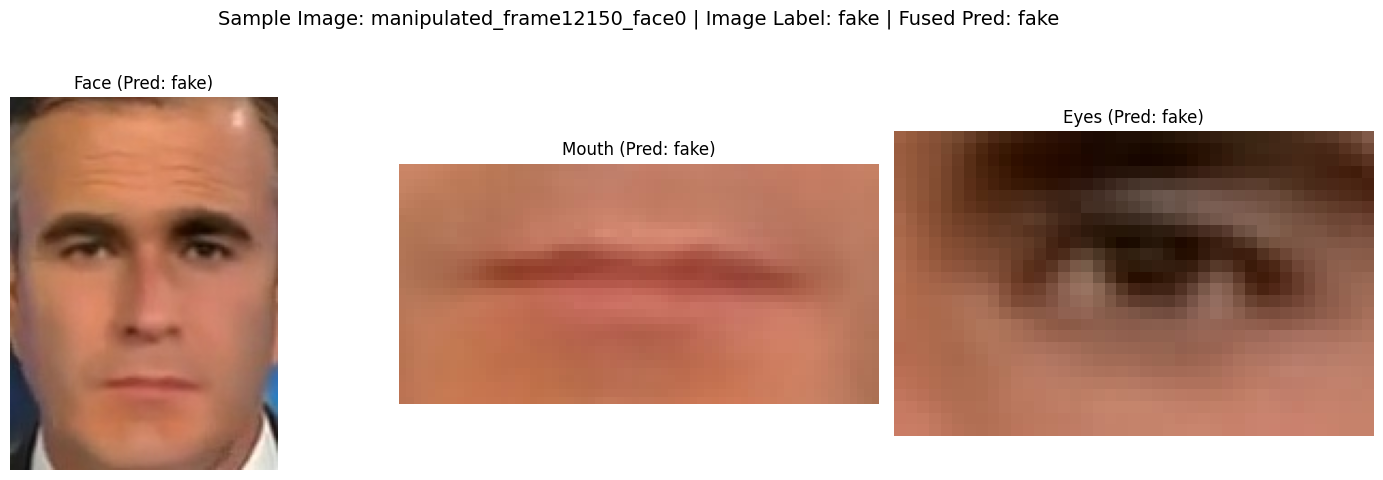

In [ ]:
# RUN FUSION EVALUATION

fusion_weights = compute_model_weights(
    mouth_acc=mouth_acc,
    eyes_acc=eyes_acc,
    face_acc=face_acc,
)

fusion_acc, fusion_results = fuse_model_outputs(
    mouth_results=mouth_results,
    eyes_results=eyes_results,
    face_results=face_results,
    weights=fusion_weights,
)

print("\nUsing Fusion Model (Mouth + Eyes + Face):")
print(f"[Fusion] Overall accuracy on common samples: {fusion_acc:.4f}")
if len(fusion_results) > 0:
    example_result = fusion_results[500]
    print("Example fusion result:")
    # Display images
    display_fused_sample_images(example_result)
else:
    print("No fusion samples")